### Bayesian, CART, ensemble

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import graphviz
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
from yellowbrick.model_selection import learning_curve


In [59]:
X, y = fetch_california_housing(return_X_y=True)


In [66]:
print(X.shape[0], 'examples')
print(X.shape[1], 'features')
feature_names = fetch_california_housing().feature_names
print(feature_names)

df = pd.DataFrame(X, columns=feature_names)
df['MedHouseValue'] = y
# plot = sns.pairplot(data)
#possible to combine all 3 histograms into 1 

20640 examples
8 features
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


### Bayesian Regression

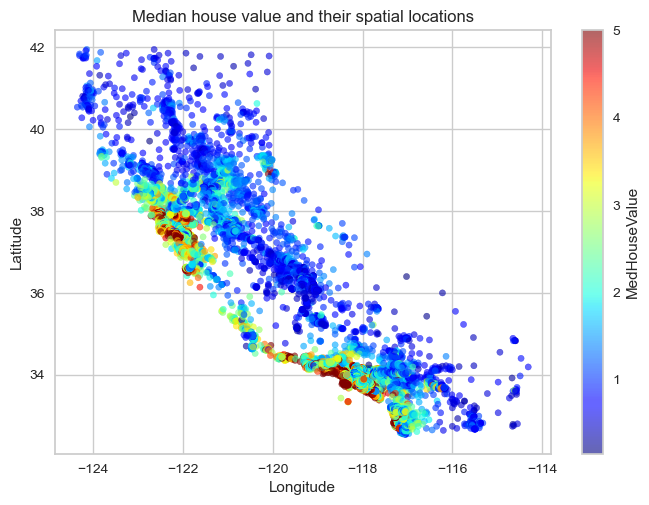

In [67]:
df.plot(kind="scatter", x='Longitude', y='Latitude', alpha=0.6, c="MedHouseValue", cmap=plt.get_cmap("jet"))
plt.title("Median house value and their spatial locations")
plt.show()


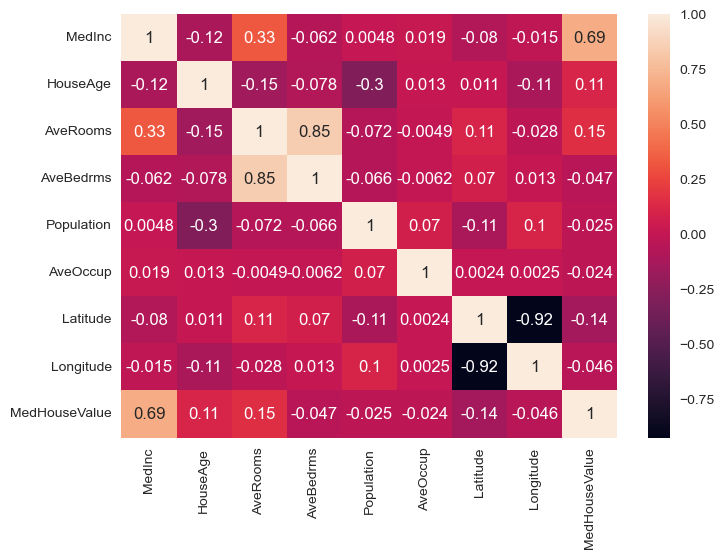

In [68]:
df.corr() #gives the correlation of the dataset
sns.heatmap(data.corr(), annot=True)
plt.show()

In [69]:
#pre-processing
df = df.sample(n=len(df), random_state=1)  #shuffling dataset
df.duplicated().count() #shows no duplicated data
df.describe()
df.dtypes
df.isnull().mean()

MedInc           0.0
HouseAge         0.0
AveRooms         0.0
AveBedrms        0.0
Population       0.0
AveOccup         0.0
Latitude         0.0
Longitude        0.0
MedHouseValue    0.0
dtype: float64

In [74]:
n = 500
true_w0 = 10
true_w1 = 10
true_sigma = 1
x = np.linspace(0, 1, n)
y = true_w0 + true_w1*x + np.random.normal(scale=true_sigma, size=n)

In [91]:
num_samples = 1000
with pm.Model() as model:
    w0 = pm.Normal('w0', mu=3.87, sigma=1.90) #medinc
    w1 = pm.Normal('w1', mu=28.64, sigma=12.59) #houseage

## auxiliary variables
    y_est = w0 + w1 * x 
    sigma = pm.Uniform('sigma', lower=0, upper=20 )
#     y_est = df['MedHouseValue'] # auxiliary variables
    likelihood = pm.Normal('y_est', mu=y_est, sigma=sigma, observed=y)
    
    sampler = pm.NUTS()

    
#     trace = pm.sample(1000, sampler)
    trace = pm.sample(num_samples, sampler, progressbar=True, cores=2, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w0, w1, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


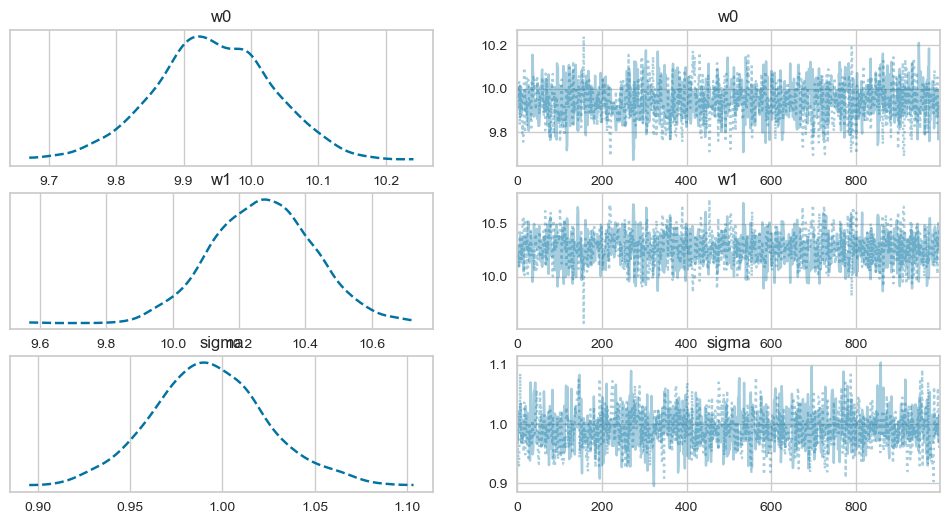

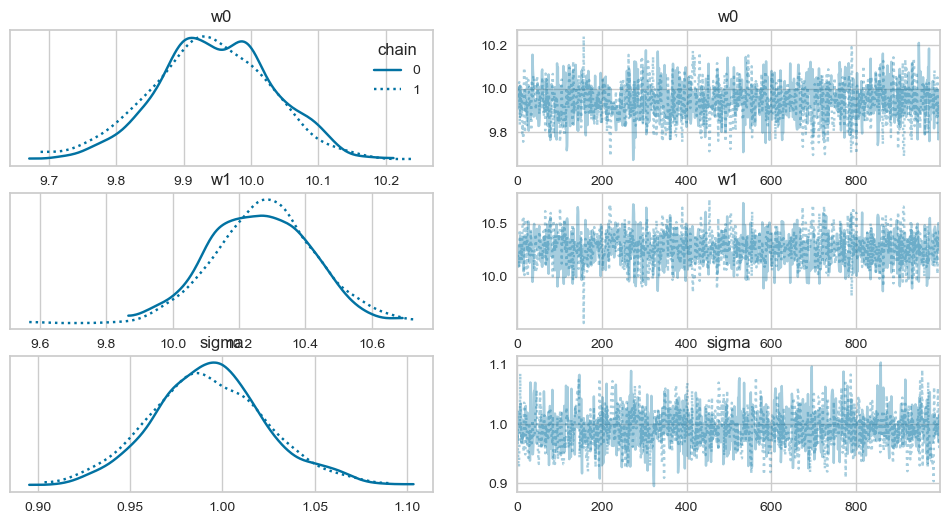

<Figure size 2000x2000 with 0 Axes>

In [92]:
az.plot_trace(trace, combined=True)
az.plot_trace(trace,legend=True)
plt.figure(figsize=(20,20))
plt.show()


In [90]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,9.945,0.088,9.781,10.111,0.001,0.000,18723.0,19658.0,1.0
w1,10.269,0.153,9.965,10.538,0.001,0.001,18373.0,20467.0,1.0
sigma,0.994,0.032,0.931,1.050,0.000,0.000,25989.0,24861.0,1.0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

In [19]:
regr = DecisionTreeRegressor(max_depth=3)
model = regr.fit(X_train, y_train)
regr_predict = regr.predict(X_test)
regr_predict.shape


(4128,)

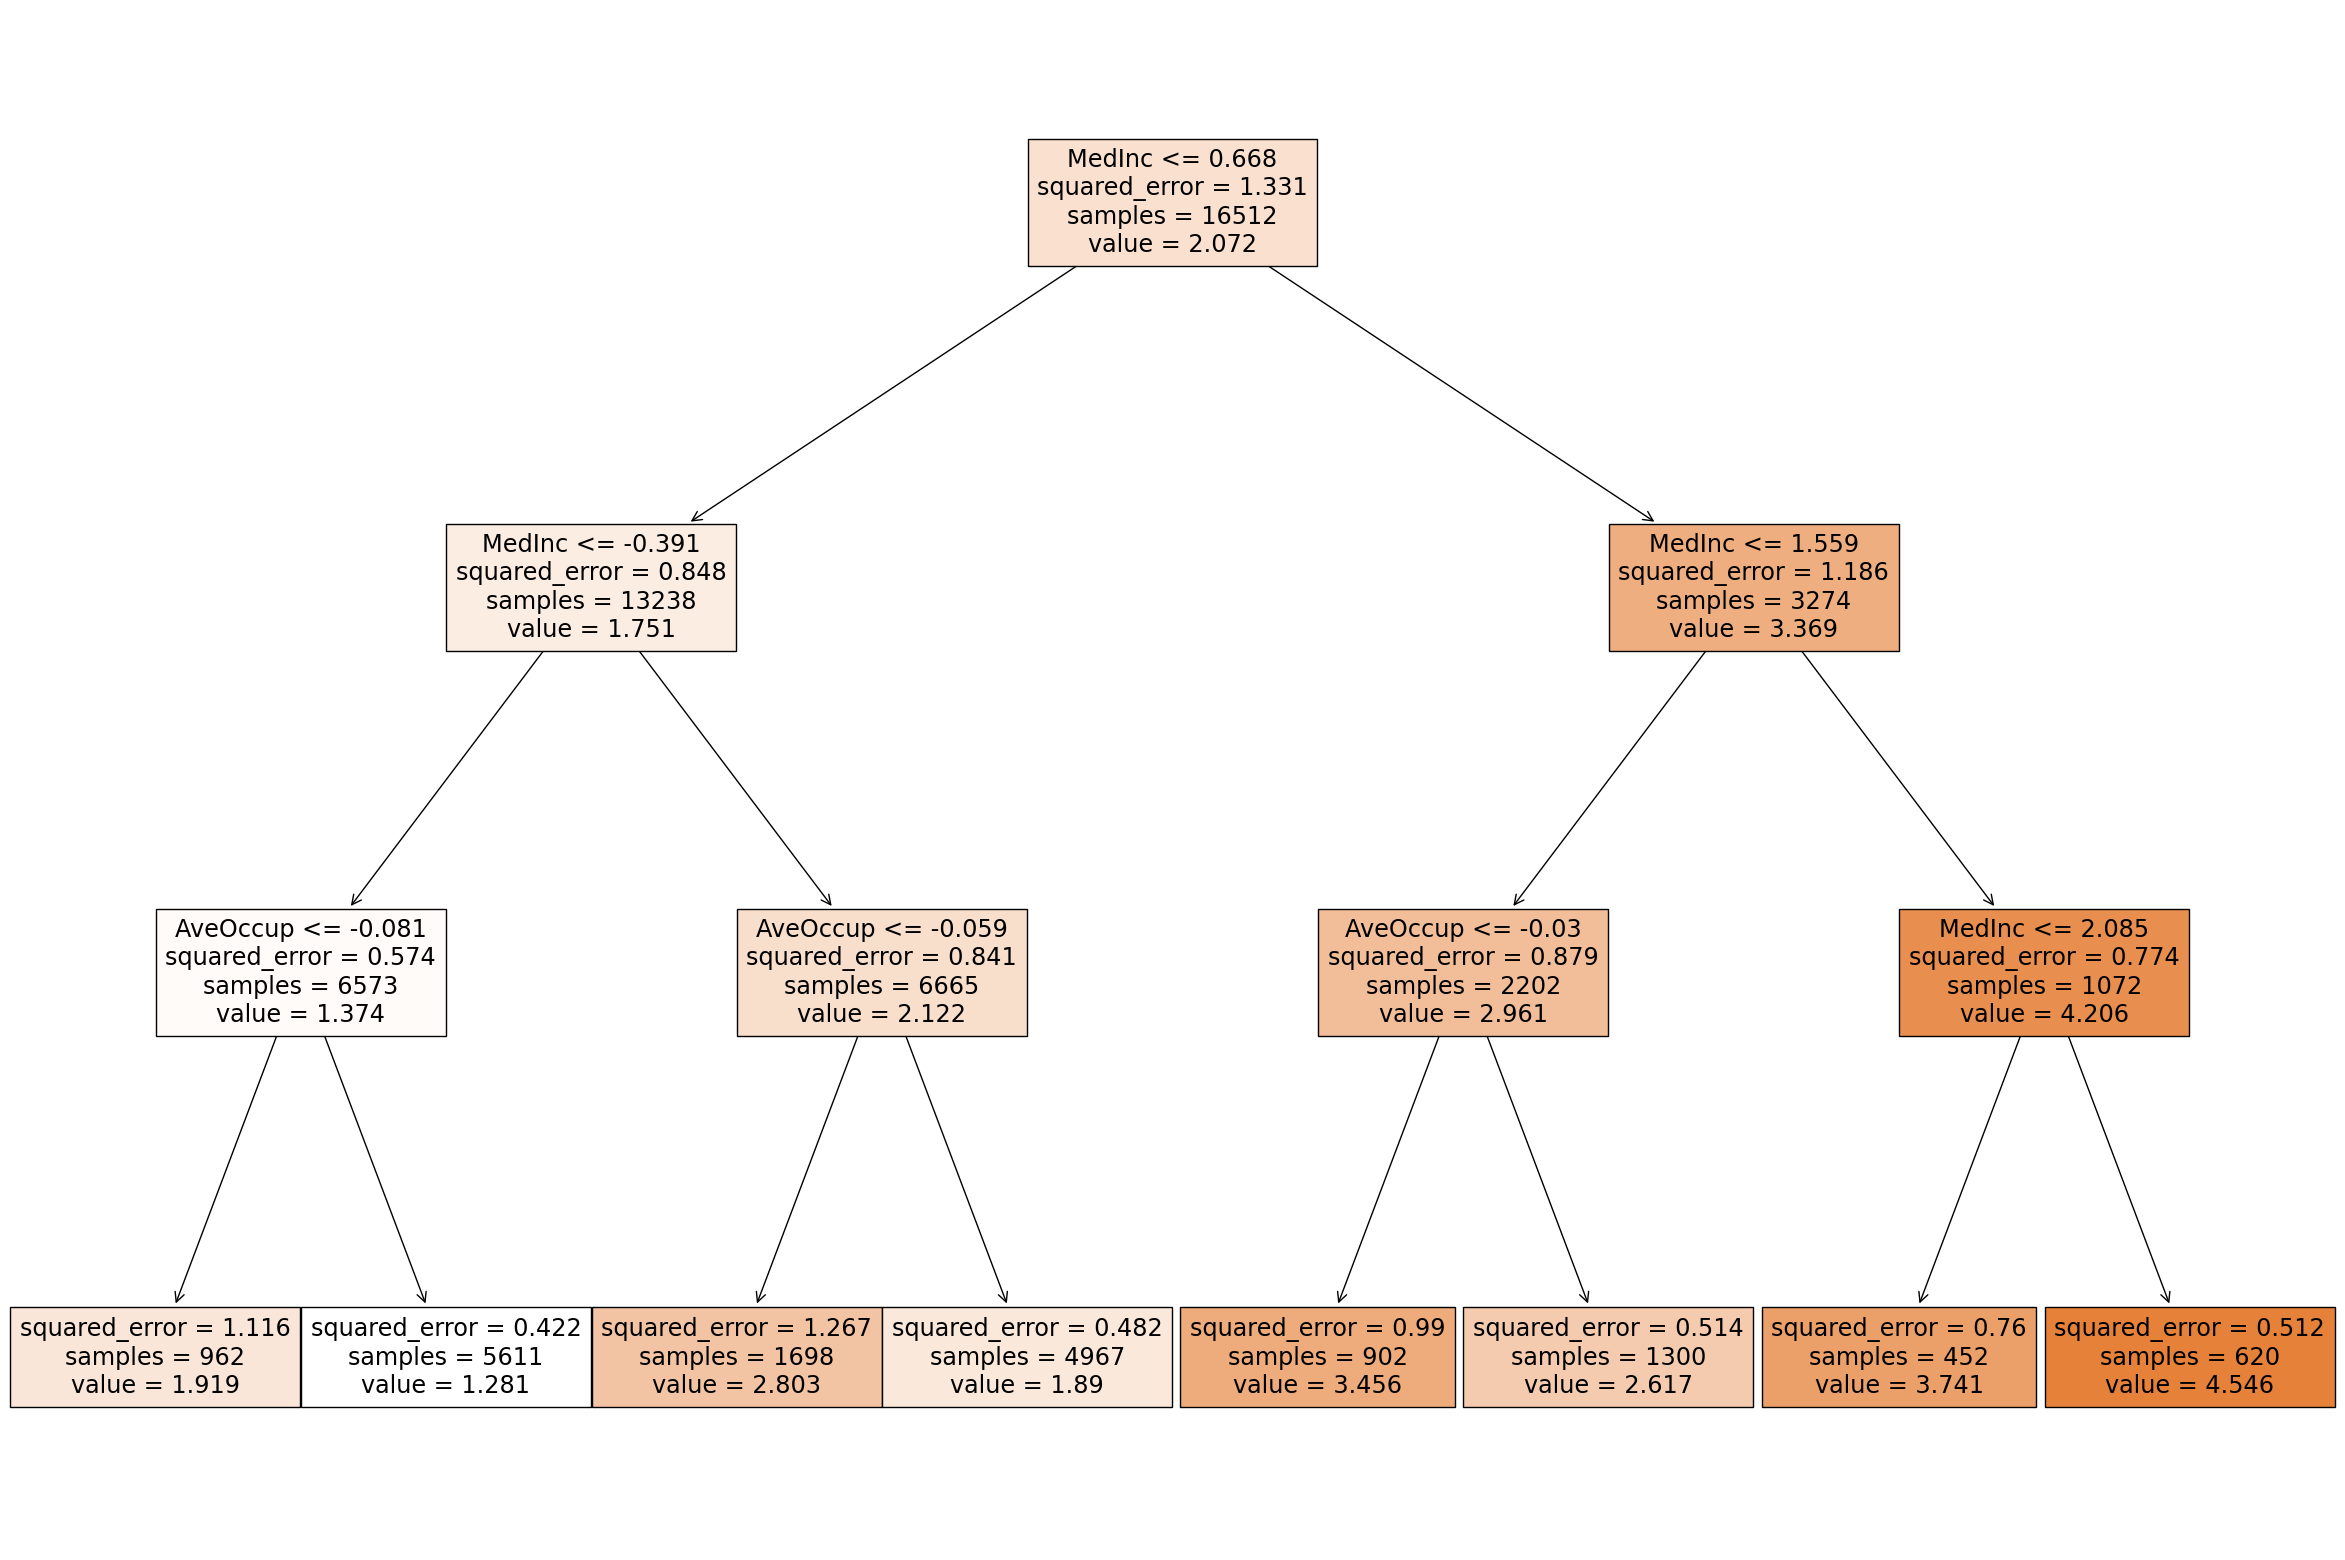

In [20]:
text_representation = tree.export_text(regr)
feature_names = fetch_california_housing().feature_names
fig = plt.figure(figsize=(30,20))
graph = tree.plot_tree(regr, feature_names=feature_names, filled=True)
plt.show()
# https://practicaldatascience.co.uk/machine-learning/how-to-use-model-selection-and-hyperparameter-tuning

In [44]:
model_dtr = DecisionTreeRegressor()

In [45]:
model_dtr.fit(X_train,y_train)

DecisionTreeRegressor()

In [46]:
y_dtr = model_dtr.predict(X_test)

In [21]:
model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [93]:
param_grid = dict(
max_depth=[50,90,150,200,1000],
min_samples_leaf=[10,20,40,60,100,500],
min_samples_split=[40,60,100,500])

In [96]:
grid_search = GridSearchCV(estimator=model_dtr, param_grid=param_grid, scoring='neg_root_mean_squared_error')

In [97]:
best_model = grid_search.fit(X_train, y_train)


In [51]:
best_model.best_params_

{'max_depth': 90, 'min_samples_leaf': 20, 'min_samples_split': 40}

In [52]:
model_test = DecisionTreeRegressor(max_depth=90, min_samples_leaf=20, min_samples_split=40)

In [53]:
model_test.fit(X_train, y_train)
y_pred = model_test.predict(X_test)

In [57]:
model_test.loss_curve_

AttributeError: 'DecisionTreeRegressor' object has no attribute 'loss_curve_'

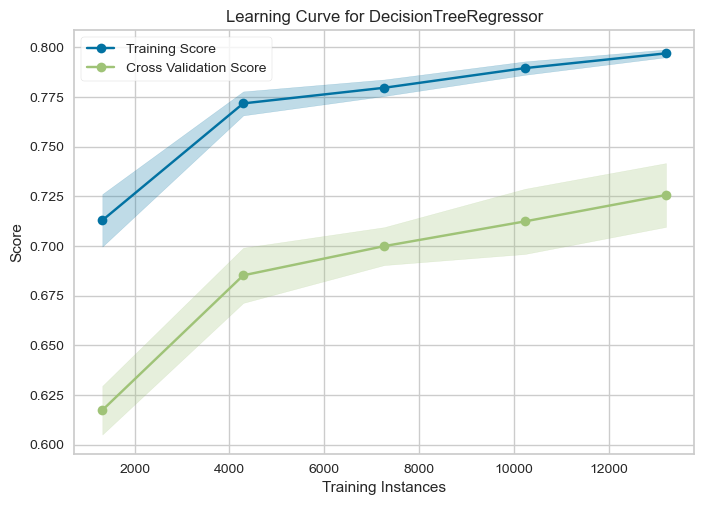

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [28]:
learning_curve(estimator=model_test, X=X_train, y=y_train)

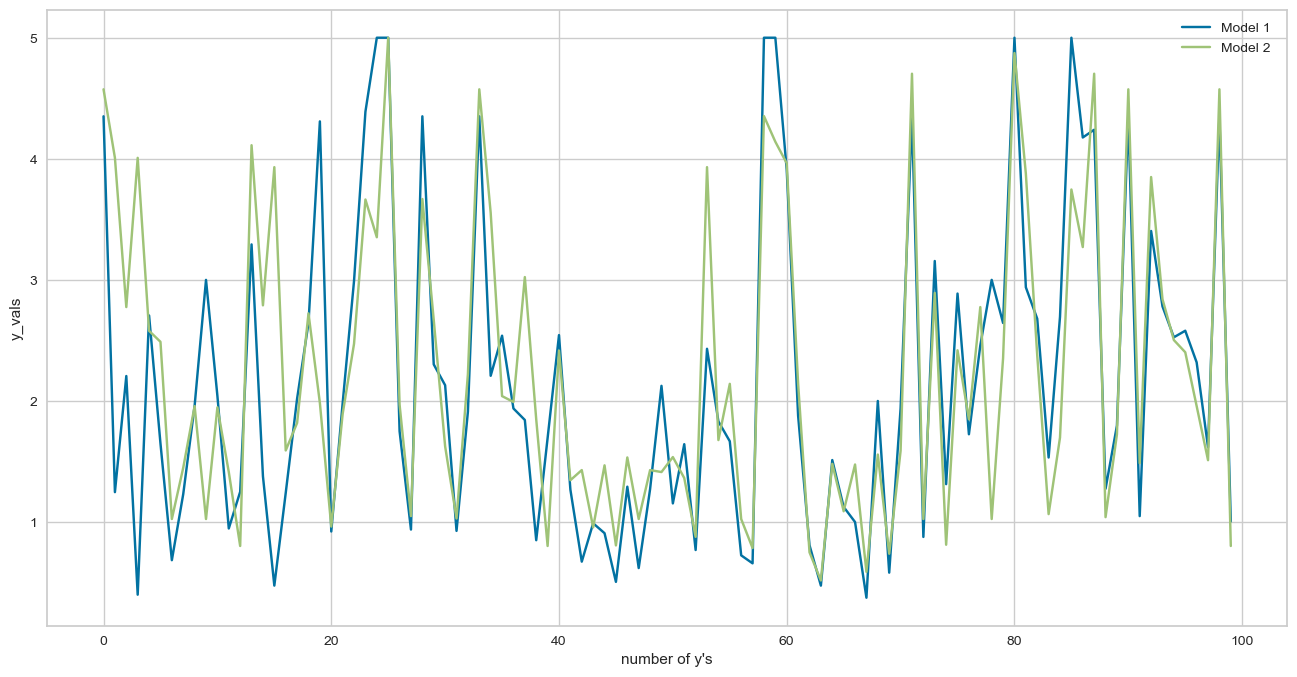

In [54]:
test = pd.DataFrame({'Model 1':y_dtr, 'Model 2':y_pred})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'], axis=1)
plt.plot(test[:100])
plt.legend(['Model 1 ','Model 2'])
plt.xlabel("number of y's")
plt.ylabel("y_vals")
plt.show()

### Ensemble Methods

In [116]:
rfr = RandomForestRegressor(n_estimators=100,max_depth=3)

In [117]:
X_train.shape #16512, 8
y_train.shape #16512, 8

(16512,)

In [118]:
rfr.fit(X_train, y_train)


RandomForestRegressor(max_depth=3)

In [125]:
y_rfr = rfr.predict(X_test)

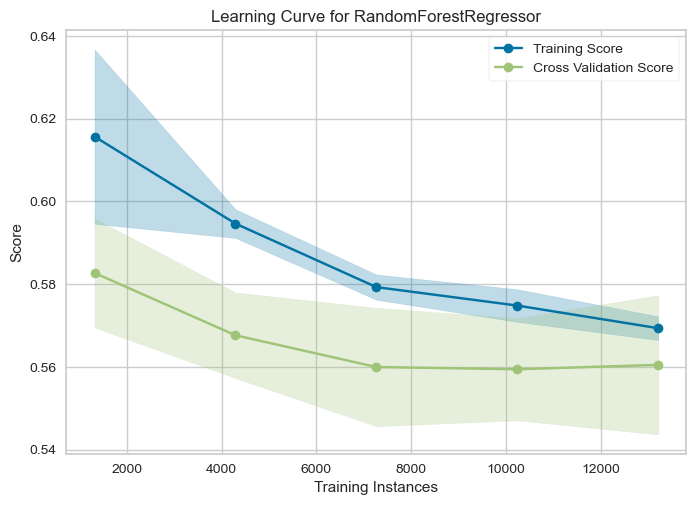

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [119]:
learning_curve(estimator=rfr, X=X_train, y=y_train)

In [112]:
param_grid = dict(
n_estimators=[100,200,300,500,700,1000])

In [113]:
model = GridSearchCV(estimator=rfr, param_grid=param_grid)

In [114]:
best_model = model.fit(X_train, y_train)

In [115]:
best_model.best_params_

{'n_estimators': 500}

In [ ]:
best_rfr = RandomForestRegressor(n_estimators=1000,max_depth=3)
best_rfr.fit(X_train, y_train)

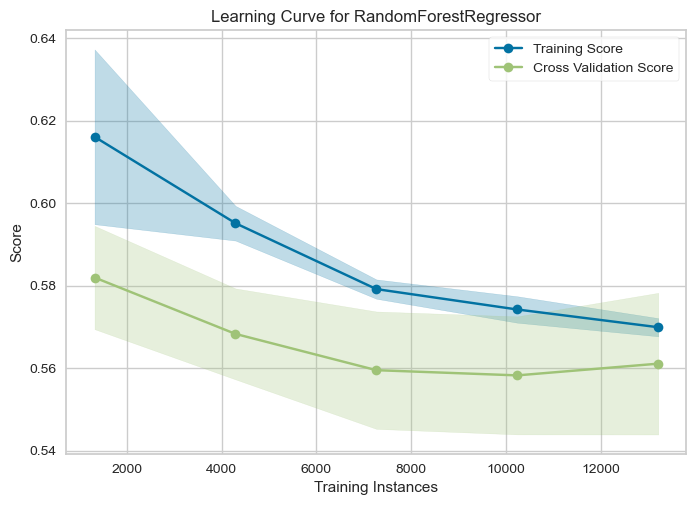

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [123]:
learning_curve(estimator=best_rfr, X=X_train, y=y_train)

In [124]:
y_best = best_rfr.predict(X_test)

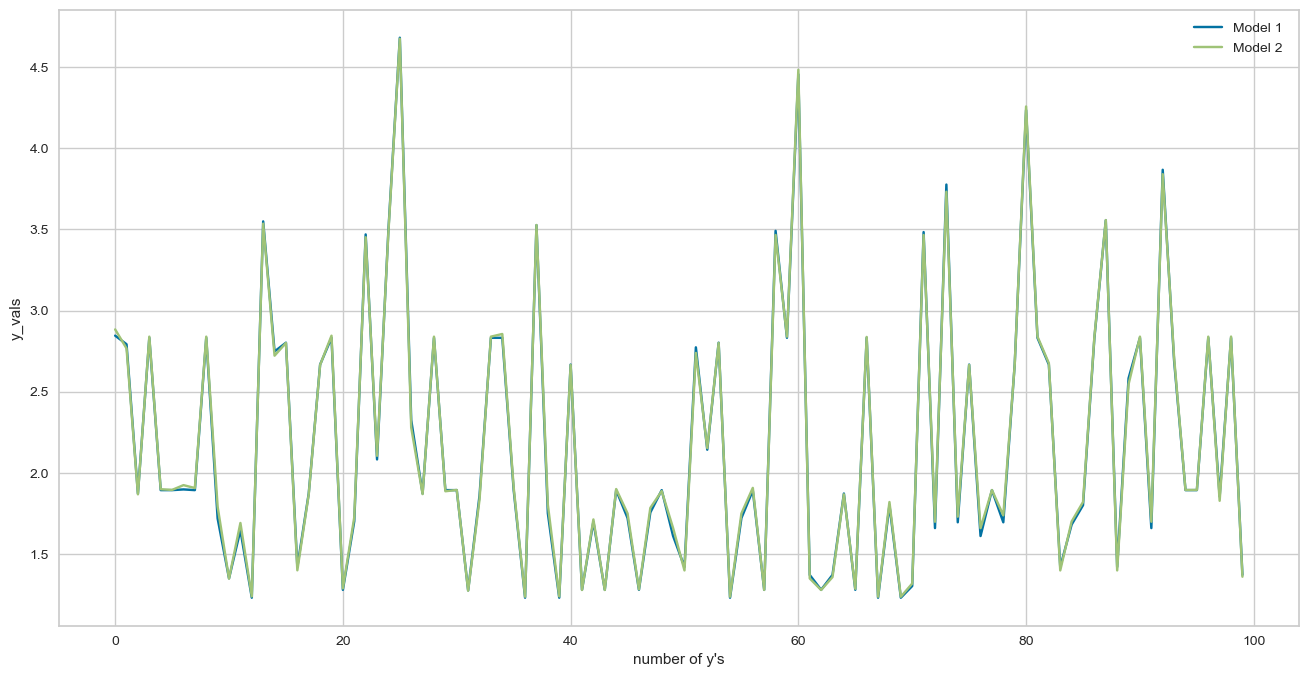

In [126]:
test = pd.DataFrame({'Model 1':y_rfr, 'Model 2':y_best})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'], axis=1)
plt.plot(test[:100])
plt.legend(['Model 1 ','Model 2'])
plt.xlabel("number of y's")
plt.ylabel("y_vals")
plt.show()